In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

(450, 90)
RAC2d (40500,)
(100,)


## load the snapshot first to prove this

In [2]:
# we need to load the miniaste

dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [3]:
layers_path

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/'

In [4]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [5]:
# we will select a SINGLE cell and do the budget for this cell

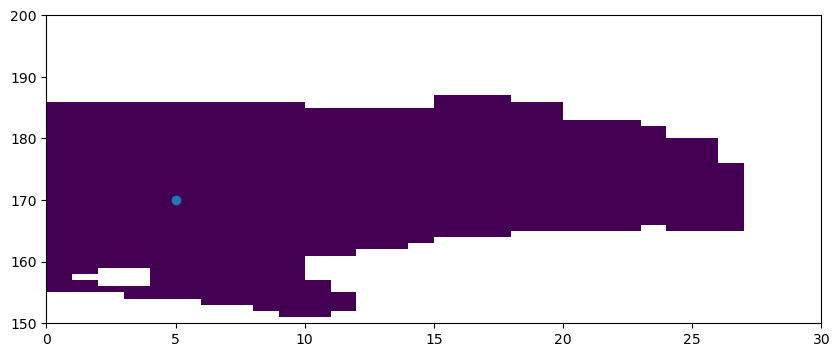

In [6]:
plt.pcolormesh(mymsk)
plt.ylim(150,200)
plt.xlim(0,30)

# pick a random point
ix = 5
iy = 170
iz = 0  # surface point
plt.scatter(ix,iy)

In [7]:
# load the ADV terms for the Barents Sea for this singular box -- single box will all be contributing the same
# to the same T or S bin, so these will be the same when plotted in T or S space
# but we can show this anyways
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [8]:
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [13]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconv

trWtopADV = -(ADVr_SLT)

ADVrS = np.zeros((nz,ny,nx),dtype=float)
ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [14]:
# define the other terms (all)

# cool, do the same for diff


## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_SLT.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhS = DF_hconv

trWtopDF = -(DFrE_SLT+DFrI_SLT)

DFrS = np.zeros((nz,ny,nx),dtype=float)
DFrS[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

# load the surface terms
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

RAC3 = np.tile(RAC[np.newaxis,:,:],(nz,1,1))
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s

def surface_contrib_JT(zconv_top_salt, sptop, rho, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = sptop.shape

    eS = zconv_top_salt.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(sptop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eS[0] - sptop[1]) / rho if np.ndim(binwidthS)==0 else \
           (eS[0] - sptop[1]) / rho

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz] = -(sptop[1:nz] - sptop[0:nz-1]) / rho

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftest = surface_contrib_JT(zconv_top_salt,sptop,myparms['rhoconst'])    # this is in PSU.m^3/s

# do the vertical convergence for KPP
trWtopKPP = -(KPPg_SLT)         # PSU.m^3/s

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / 1    # PSU.m/s
#print(np.nansum(SALTDR),dt)

tmptend = (SALTDR - 0) * mk3D_mod(RAC,SALTDR)    # PSU.m/s * m^2 = PSU.m^3/s

In [15]:
# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[iz,iy,ix] = 1  # set the single point to mymsk3d

# define the ADVh total for this mymsk2
G_S_offline_new = np.zeros((7, nS-1))
dF_Snew = np.zeros((7, nS-1))
Lijnew = np.zeros((7, nS-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
S_flat    = np.ravel(SALT*hf* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhS*hf* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrS*hf* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhS*hf* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrS*hf* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest*hf* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp*hf* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend*hf* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((S_flat >= binmidS[i]) & (S_flat < binmidS[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Snew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Snew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Snew[2, i] = np.nansum(DFh_flat[ij])
        dF_Snew[3, i] = np.nansum(DFr_flat[ij])
        dF_Snew[4, i] = np.nansum(surf_flat[ij])
        dF_Snew[5, i] = np.nansum(kpp_flat[ij])
        dF_Snew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_S_offline_new = dF_Snew / binwidthS1[None, :]

In [17]:
s = 0 
labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])

for i in range(6):
    at = np.nansum(dF_Snew[i]) / np.nansum(binwidthS1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
# print("total volume tend LHS: ",np.nansum(dF_Snew[-1]/1.8e3) / np.nansum(binwidthS1),"m^3/s")

ADVh         5172.078410097844 m^3/s
ADVr         -5405.166125936456 m^3/s
DFh         -0.12251056471163535 m^3/s
DFr         41.93199621992488 m^3/s
surf         0.0 m^3/s
kpp         0.0 m^3/s

total volume tend RHS:  -191.27823018339873 m^3/s


In [18]:
# now calculate the 5 gates (ie one is the surface)
ADVx_SLT = ADVx_SLT.reshape((nz,ny,nx))
ADVy_SLT = ADVy_SLT.reshape((nz,ny,nx))
ADVr_SLT = ADVr_SLT.reshape((nz,ny,nx))
M1S = ADVx_SLT[iz,iy,ix]     # south gate
M2S = -ADVx_SLT[iz,iy,ix+1]  # north gate
M3S = ADVy_SLT[iz,iy,ix]     # east gate in
M4S = -ADVy_SLT[iz,iy+1,ix]  # west gate in
MbS = ADVr_SLT[iz+1,iy,ix]   # bottom gate in

In [19]:
iMs = [np.where(dF_Snew[0]!=0)]
mywidS = binwidthS1[iMs]  # this is the binwidth we divide by in this example


In [20]:
M_S_offline_new = np.zeros((6, nT-1))  # include one for sum of bins
M_S_offline_new[0,iMs] = M1S / mywidS  # becomes m^3/s
M_S_offline_new[1,iMs] = M2S / mywidS  # becomes m^3/s
M_S_offline_new[2,iMs] = M3S / mywidS  # becomes m^3/s
M_S_offline_new[3,iMs] = M4S / mywidS  # becomes m^3/s
M_S_offline_new[4,iMs] = MbS / mywidS  # becomes m^3/s
M_S_offline_new[5,iMs] = (M1S+M2S+M3S+M4S) / mywidS  # becomes m^3/s
labels_M = np.array(["S","N","E","W","Bot","allH"])

In [21]:
iMs

[(array([91]),)]

Text(0, 0.5, 'm^3/s')

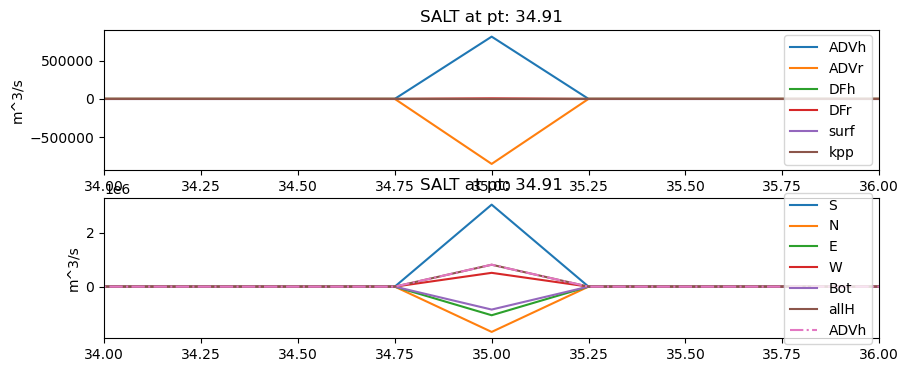

In [22]:
fig = plt.figure()

ax = plt.subplot(211)
for i in range(6):
    ax.plot(boundsS.flatten()[1:-1],G_S_offline_new[i],label = labels[i])

ax.legend(loc="right")
ax.set_xlim(34,36)
ax.set_title(f"SALT at pt: {SALT[iz,iy,ix]:.2f}")
ax.set_ylabel("m^3/s")


ax = plt.subplot(212)
for i in range(6):
    ax.plot(boundsS.flatten()[1:-1],M_S_offline_new[i],label = labels_M[i])

# add the ADVh to this to compare
ax.plot(boundsS.flatten()[1:-1],G_S_offline_new[0],label = labels[0],linestyle = "-.")
ax.legend(loc="right")
ax.set_xlim(34,36)
ax.set_title(f"SALT at pt: {SALT[iz,iy,ix]:.2f}")
ax.set_ylabel("m^3/s")


In [70]:
# SALT[iz,iy,ix]

## Propose an alternative using UVELMASS and VVELMASS at the gates

We already know these are about the same as doing ADV/face theta (shown in previous notebooks)

In [93]:
# Load the UVELMASS and VVELMASS terms
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
ADVr_TH = ADVr_TH.reshape((nz,ny,nx))

DFxE_TH = DFxE_TH.reshape((nz,ny,nx))
DFyE_TH = DFyE_TH.reshape((nz,ny,nx))
DFrE_TH = DFrE_TH.reshape((nz,ny,nx))

KPPg_TH = KPPg_TH.reshape((nz,ny,nx))

UVELMASS = UVELMASS.reshape((nz,ny,nx))
VVELMASS = VVELMASS.reshape((nz,ny,nx))

Ft_surftest.shape

(50, 450, 90)

In [94]:
print(iy,ix)

170 5


In [88]:
# load the THETADR at the snaps

In [92]:
t2 = int(tsstr[1])

THETA = np.zeros((len(tsstr),nz,ny,nx))
SALT = np.zeros((len(tsstr),nz,ny,nx))

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for i in range(len(tsstr)):
    t2 = int(tsstr[i])
    THETAi,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
    SALTi,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

    THETAi = THETAi.reshape(nz,ny,nx)
    SALTi = SALTi.reshape(nz,ny,nx)

    THETA[i] = THETAi
    SALT[i] = SALTi

In [96]:
dt = 86400

In [103]:
boundsT.shape

(113, 1, 1)

In [111]:
THETA_n = THETA[0]
THETA_np1 = THETA[1]
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))
RAC3d = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))
hFacC = mygrid['hFacC']
V = DRF3d * RAC3d * hFacC

# ---------------------------
# Inputs you have
# ---------------------------
# THETA_n, THETA_np1: snapshots at t^n and t^{n+1}, shape (nz,ny,nx), degC
# DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH: shape (nz,ny,nx), degC*m^3/s (cell-centered)
# Ft_surftest: shape (nz,ny,nx), degC*m^3/s (cell-centered)
# UVELMASS, VVELMASS: for gates, either m^3/s (transport) OR m/s (velocity)
# binmidT: shape (nT,), bin midpoints (degC)
# dt: seconds between snapshots
# V: cell volume (m^3), shape (nz,ny,nx) = drF*RAC*hFacC

# ---------------------------
# 1) Build bin edges from binmidT
# ---------------------------
def edges_from_midpoints(mid):
    mid = np.asarray(mid)
    # interior edges are midpoints between mids
    edges = np.empty(mid.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (mid[:-1] + mid[1:])
    # extrapolate outer edges
    edges[0]  = mid[0]  - (edges[1] - mid[0])
    edges[-1] = mid[-1] + (mid[-1] - edges[-2])
    return edges

binEdgesT = edges_from_midpoints(boundsT.flatten()[1:-1])   # length = nT+1

def bin_index(theta, edges):
    edges = np.asarray(edges)
    # validate once
    if edges.ndim != 1 or not np.all(np.diff(edges) > 0):
        raise ValueError("edges must be 1D and strictly increasing.")

    nb = len(edges) - 1

    # clip into [edges[0], nextafter(edges[-1], -inf)]
    hi = np.nextafter(edges[-1], -np.inf)
    theta_clip = np.clip(theta, edges[0], hi)

    idx = np.digitize(theta_clip, edges, right=False) - 1  # 0..nb-1
    # idx should now be safe, but keep hard guard:
    idx[(idx < 0) | (idx >= nb)] = -1
    return idx


# ---------------------------
# 2) Define a small region around (y=170,x=5)
#    (choose a neighborhood; here +/-1 in each direction)
# ---------------------------
def region_mask(nz, ny, nx, y0=170, x0=5, dy=1, dx=1):
    m2 = np.zeros((ny, nx), dtype=bool)
    ys = slice(max(0, y0-dy), min(ny, y0+dy+1))
    xs = slice(max(0, x0-dx), min(nx, x0+dx+1))
    m2[ys, xs] = True
    m3 = np.broadcast_to(m2, (nz, ny, nx)).copy()
    return m2, m3

m2, m3 = region_mask(nz, ny, nx, y0=170, x0=5, dy=1, dx=1)

# ---------------------------
# 3) Gate exchange spectrum G_k (m^3/s per theta bin)
#    computed on the perimeter of the masked region.
#
#    This version assumes UVELMASS and VVELMASS are on C-cells as "through-cell" values
#    (your reshape to (nz,ny,nx) suggests that), so we treat:
#      UVELMASS[k,j,i] = transport across the EAST face of cell (i,j) (or similar).
#    If your UVELMASS/VVELMASS are actually on faces with nx+1/ny+1, adjust indexing accordingly.
# ---------------------------

def gate_exchange_from_UV_on_Cgrid(
    THETA, U, Vv, mask2, edges, U_is_transport=True,
    face_area_U=None, face_area_V=None,
):
    """
    THETA: (nz,ny,nx) degC
    U:     (nz,ny,nx) either transport (m^3/s) or velocity (m/s)
    Vv:    (nz,ny,nx) same
    mask2: (ny,nx) bool region
    edges: bin edges
    If U_is_transport=False, provide face_area_U, face_area_V in m^2 so Q=U*Area.
    Returns G (nBins,) m^3/s into region, binned by upwind theta.
    """
    nz, ny, nx = THETA.shape
    print(len(edges))
    nb = len(edges) - 1
    print(nb)
    G = np.zeros(nb, dtype=float)

    # helper to add contributions
    def add_flux(Q_into, theta_up):
        b = bin_index(theta_up, edges)
        ok = (b >= 0) & np.isfinite(Q_into) & np.isfinite(theta_up)
        np.add.at(G, b[ok], Q_into[ok])

    # Convert to transports if needed
    if not U_is_transport:
        if face_area_U is None or face_area_V is None:
            raise ValueError("Need face_area_U/face_area_V if U,V are velocities (m/s).")
        UQ = U * face_area_U  # m^3/s
        VQ = Vv * face_area_V
    else:
        UQ = U
        VQ = Vv

    # Iterate over boundary faces of mask2.
    # Convention here (you must match your diagnostic):
    # - UQ[...,j,i] is transport from cell (i,j) to (i+1,j) when positive.
    # - VQ[...,j,i] is transport from cell (i,j) to (i,j+1) when positive.

    for j in range(ny):
        for i in range(nx):
            if not mask2[j, i]:
                continue

            # EAST face: neighbor at (i+1,j) outside mask => gate face
            if i+1 < nx and (not mask2[j, i+1]):
                Q = UQ[:, j, i]  # positive means out of cell to the east
                # Into region is negative Q (flow from outside->inside across east face)
                # Upwind theta: if Q<0, upstream is east neighbor; else upstream is inside cell.
                theta_in  = THETA[:, j, i]
                theta_out = THETA[:, j, i+1]
                theta_up = np.where(Q < 0, theta_out, theta_in)
                Q_into = -Q
                add_flux(Q_into, theta_up)

            # WEST face: neighbor at (i-1,j) outside mask
            if i-1 >= 0 and (not mask2[j, i-1]):
                # transport across west face is stored on neighbor cell (i-1) east face in this convention
                Q = UQ[:, j, i-1]  # positive means from (i-1)->(i) into region
                theta_out = THETA[:, j, i-1]
                theta_in  = THETA[:, j, i]
                theta_up = np.where(Q > 0, theta_out, theta_in)
                Q_into = Q
                add_flux(Q_into, theta_up)

            # NORTH face: neighbor at (i,j+1) outside mask
            if j+1 < ny and (not mask2[j+1, i]):
                Q = VQ[:, j, i]  # positive means out of cell to the north
                theta_in  = THETA[:, j, i]
                theta_out = THETA[:, j+1, i]
                theta_up = np.where(Q < 0, theta_out, theta_in)
                Q_into = -Q
                add_flux(Q_into, theta_up)

            # SOUTH face: neighbor at (i,j-1) outside mask
            if j-1 >= 0 and (not mask2[j-1, i]):
                Q = VQ[:, j-1, i]  # positive means from (i,j-1)->(i,j) into region
                theta_out = THETA[:, j-1, i]
                theta_in  = THETA[:, j, i]
                theta_up = np.where(Q > 0, theta_out, theta_in)
                Q_into = Q
                add_flux(Q_into, theta_up)

    return G

# Example call:
# Set this correctly:
U_is_transport = True  # set False if your "UVELMASS" is actually m/s
UVol = UVELMASS * np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
VVol = VVELMASS * np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))

G_k = gate_exchange_from_UV_on_Cgrid(THETA_n, UVol, VVol, m2, binEdgesT, U_is_transport=U_is_transport)

# ---------------------------
# 4) Internal mixing + surface forcing as conservative bin-to-bin transfers
# ---------------------------
def wmt_transfer_from_diabatic_terms(
    THETA, V, dt, edges, mask3d,
    DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH, Ft_surf
):
    """
    All diabatic terms are cell-centered in degC*m^3/s.
    Returns:
      D_all: (nBins,) m^3/s per theta bin (net diabatic transformation)
      D_mix: mixing-only (DF + KPP)
      D_surf: surface-only
    """
    nb = len(edges) - 1

    # Build tendencies (degC/s)
    DF_term  = DFxE_TH + DFyE_TH + DFrE_TH          # degC*m^3/s
    MIX_term = DF_term + KPPg_TH                    # degC*m^3/s
    SURF_term = Ft_surf                             # degC*m^3/s

    dtheta_dt_mix  = (MIX_term  / V)
    dtheta_dt_surf = (SURF_term / V)
    dtheta_dt_all  = dtheta_dt_mix + dtheta_dt_surf

    # Predict theta* for each contribution separately
    theta_star_mix  = THETA + dtheta_dt_mix  * dt
    theta_star_surf = THETA + dtheta_dt_surf * dt
    theta_star_all  = THETA + dtheta_dt_all  * dt

    def bin_to_bin(theta0, theta1):
        oldb = bin_index(theta0, edges)
        newb = bin_index(theta1, edges)
    
        valid = (oldb >= 0) & (newb >= 0)
        moved = valid & (newb != oldb) & (mask3d > 0)
    
        trans = (V / dt) * mask3d  # m^3/s
    
        D = np.zeros(nb, dtype=float)
    
        # Safety: mask out any residual bad indices (should be none now)
        moved &= (oldb < nb) & (newb < nb)
    
        np.add.at(D, oldb[moved], -trans[moved])
        np.add.at(D, newb[moved], +trans[moved])
        return D


    D_mix  = bin_to_bin(THETA, theta_star_mix)
    D_surf = bin_to_bin(THETA, theta_star_surf)
    D_all  = bin_to_bin(THETA, theta_star_all)

    return D_all, D_mix, D_surf

D_all, D_mix, D_surf = wmt_transfer_from_diabatic_terms(
    THETA_n, V, dt, binEdgesT, m3.astype(float),
    DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH, Ft_surftest
)

# ---------------------------
# 5) Optional: snapshot volume tendency per bin (LHS)
# ---------------------------
def bin_volume(theta, V, edges, mask3d=None):
    nb = len(edges) - 1
    if mask3d is None:
        mask3d = 1.0
    b = bin_index(theta, edges)
    Vk = np.zeros(nb, dtype=float)
    ok = (b >= 0) & (mask3d > 0)
    np.add.at(Vk, b[ok], (V * mask3d)[ok])
    return Vk

Vk_n   = bin_volume(THETA_n,   V, binEdgesT, mask3d=m3.astype(float))
Vk_np1 = bin_volume(THETA_np1, V, binEdgesT, mask3d=m3.astype(float))
dVk_dt = (Vk_np1 - Vk_n) / dt  # m^3/s per bin

# ---------------------------
# 6) Closure check (per bin)
# ---------------------------
# For a WMT-style budget in this region:
#   dV/dt ≈ gate_exchange + diabatic_transformation + residual
residual = dVk_dt - (G_k + D_all)

print("sum(dVk_dt) [m^3/s] =", np.nansum(dVk_dt))
print("sum(G_k)    [m^3/s] =", G_k.sum())
print("sum(D_all)  [m^3/s] =", D_all.sum(), " (should be ~0)")
print("sum(resid)  [m^3/s] =", np.nansum(residual))# .sum(), " (should be small if everything is consistent)")


112
111
sum(dVk_dt) [m^3/s] = 0.0
sum(G_k)    [m^3/s] = -58733.59049226724
sum(D_all)  [m^3/s] = 0.0  (should be ~0)
sum(resid)  [m^3/s] = 57872.15209191605


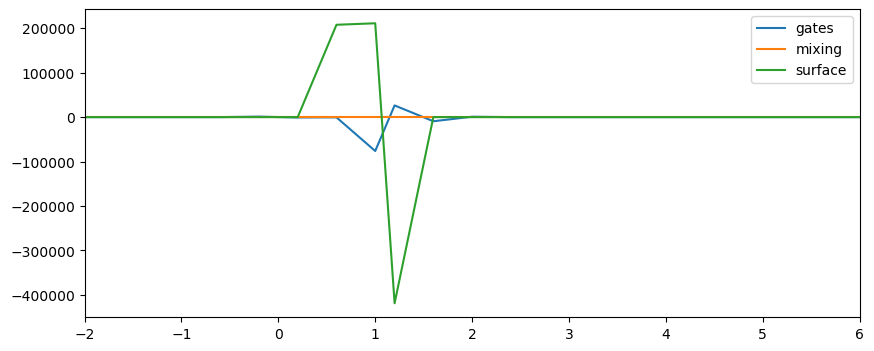

In [120]:
fig = plt.figure()

ax = plt.subplot(111)

ax.plot(boundsT.flatten()[1:-1],G_k,label="gates")
ax.plot(boundsT.flatten()[1:-1],D_mix,label="mixing")
ax.plot(boundsT.flatten()[1:-1],D_surf,label="surface")

ax.set_xlim(-2,6)
ax.legend()

In [ ]:
# this really does not make sense to me.

## Let's return to the Walin way of thinking about this

In [122]:
# ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
# ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
# ADVr_TH = ADVr_TH.reshape((nz,ny,nx))

# DFxE_TH = DFxE_TH.reshape((nz,ny,nx))
# DFyE_TH = DFyE_TH.reshape((nz,ny,nx))
# DFrE_TH = DFrE_TH.reshape((nz,ny,nx))

# KPPg_TH = KPPg_TH.reshape((nz,ny,nx))

# UVELMASS = UVELMASS.reshape((nz,ny,nx))
# VVELMASS = VVELMASS.reshape((nz,ny,nx))

# Ft_surftest.shape

In [147]:
# I think we only want the DF terms where DF is moving between different bins of TH
# that would be a water mass transformation across an isothermal surface

In [152]:
# DFrE_TH[0][iy,ix]  # defined as down into the next bin

In [160]:
# THETA_n

In [174]:
col = THETA_n[:, iy, ix]          # (nz,)
col_np1 = THETA_np1[:, iy, ix]          # (nz,)

edges = np.asarray(binmidT)       # treat binmidT as edges (must be increasing)

hi = np.nextafter(edges[-1], -np.inf)

def get_col(col,edges):
    bidx_n = np.digitize(np.clip(col, edges[0], hi), edges) - 1  # 0..len(edges)-2
    bidx_n[(bidx_n < 0) | (bidx_n >= len(edges)-1)] = -1
    return bidx_n

bidx_n = get_col(col,edges)

bidx_n_xp1 = get_col(THETA_n[:,iy,ix+1],edges)
bidx_n_xm1 = get_col(THETA_n[:,iy,ix-1],edges)
bidx_n_yp1 = get_col(THETA_n[:,iy+1,ix],edges)
bidx_n_ym1 = get_col(THETA_n[:,iy-1,ix],edges)

# bidx_np1 = np.digitize(np.clip(col_np1, edges[0], hi), edges) - 1  # 0..len(edges)-2
# bidx_np1[(bidx_np1 < 0) | (bidx_np1 >= len(edges)-1)] = -1

# difference here is zero so possibly not useful

In [176]:
rightdiff = (bidx_n_xp1-bidx_n)  # where we want -DX at x+1
leftdiff = (bidx_n_xm1-bidx_n)   # where we want +DX at x
topdiff = (bidx_n_yp1-bidx_n)    # where we want -DY at y+1
botdiff = bidx_n_ym1 - bidx_n    # where we want +DY at y

In [196]:
dF_Tnew = np.zeros((8,nT-1))

for k in range(nz):
    iT = bidx_n[k]
    
    # do the gates first
    dF_Tnew[0,iT] += ADVx_TH[k,iy,ix]
    dF_Tnew[1,iT] -= ADVx_TH[k,iy,ix+1]
    dF_Tnew[2,iT] += ADVy_TH[k,iy,ix]
    dF_Tnew[3,iT] -= ADVx_TH[k,iy+1,ix]

    # we still need DFx and DFy, for this we need the indices of the surrounding bins
    if rightdiff[k] != 0:
        dF_Tnew[6,iT] -= DFxE_TH[k,iy,ix+1]
    if leftdiff[k] != 0:
        dF_Tnew[6,iT] += DFxE_TH[k,iy,ix]

    if topdiff[k] != 0:
        dF_Tnew[6,iT] -= DFyE_TH[k,iy+1,ix]
    if leftdiff[k] != 0:
        dF_Tnew[6,iT] += DFyE_TH[k,iy,ix]

for k in range(1,nz):
    iT = bidx_n[k]

    # for vertical terms, test if the value down is not the same T bin, if not, add this value
    # then it is a transformation
    if bidx_n[k] != bidx_n[k-1]:
        dF_Tnew[4,iT] += KPPg_TH[k,iy,ix]
        dF_Tnew[5,iT] += DFrE_TH[k,iy,ix]
        #dF_Tnew[6,iT] += ADVr_TH[k,iy,ix]

for k in range(nz):
    iT = bidx_n[k]
    
    dF_Tnew[7,iT] += Ft_surftest[k,iy,ix]


labels = np.array(["W","E","S","N","KPP","DFr","DFh","surf","sum"])

(-2.0, 5.0)

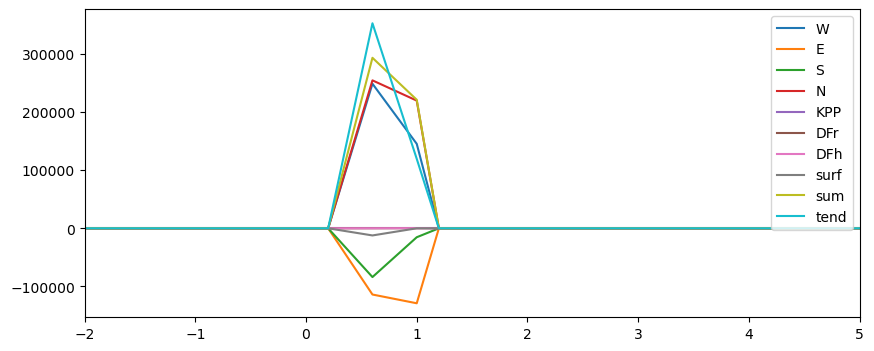

In [204]:
fig = plt.figure()

ax = plt.subplot(111)

for i in range(8):
    ax.plot(boundsT.flatten()[1:-1],dF_Tnew[i],label = labels[i])
sumterms = np.nansum(dF_Tnew,axis=0)
ax.plot(boundsT.flatten()[1:-1],sumterms,label = labels[-1])
ax.plot(boundsT.flatten()[1:-1],tend_T/2e2,label="tend")
ax.legend()
ax.set_xlim(-2,5)

In [187]:
tend_col = tmptend[:,iy,ix]

In [192]:
tend_T = np.zeros(nT-1)
tend_T

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [193]:
for k in range(nz):
    iT = bidx_n[k]
    tend_T[iT] += tend_col[k]

In [194]:
tend_T

array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        , 70607559.05879346,
       23924448.1149643 ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.     